In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"

import pickle
import random
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import joblib
import logging
from datetime import datetime
from argparse import ArgumentParser
import src.utils as utils
from src.utils import normalize_answer, find_subsequence, exact_match_score
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

/drive2/ryusejong/miniconda3/envs/dagcd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#data = utils.load_parquet_data('results/llama-2-7b-hf/HotpotQA-2000-0.2per-seed0-gen.parquet')
data = utils.load_parquet_data('results/llama-2-7b-hf/HotpotQA-2000-2per-seed0-gen.parquet')

# evaluate Greedy
print('------------------Greedy------------------')
greedy_em, _, _ = utils.evaluate_em(data, 'gold_ans', 'greedy_ans')
greedy_f1, _, _ = utils.evaluate_f1(data, 'gold_ans', 'greedy_ans')

print(f"EM: {greedy_em * 100}")
print(f"F1: {greedy_f1 * 100}\n")

# evaluate RAG Hallu
print('------------------RAG Hallu------------------')
ours_em, _, _ = utils.evaluate_em(data, 'gold_ans', 'pred_ans')
ours_f1, _, _ = utils.evaluate_f1(data, 'gold_ans', 'pred_ans')


print(f"EM: {ours_em * 100}")
print(f"F1: {ours_f1 * 100}\n")

------------------Greedy------------------
EM: 43.22
F1: 53.61

------------------RAG Hallu------------------
EM: 43.22
F1: 53.61



In [3]:
correct = []
incorrect = []
correct_marginalized_prob = []
incorrect_marginallized_prob = []

for i, item in enumerate(data):

    if exact_match_score(item['gold_ans'][0], item['pred_ans']):
        correct.append(item)
        correct_marginalized_prob.append(item['marginalized_prob'])
    else:
        incorrect.append(item)
        incorrect_marginallized_prob.append(item['marginalized_prob'])
        
print(f"Total correct: {100 * len(correct) / len(data): .2f}%")
print(f"Correct marginalized prob: {np.mean(correct_marginalized_prob): .4f}")
print(f"Incorrect marginalized prob: {np.mean(incorrect_marginallized_prob): .4f}")

Total correct:  43.22%
Correct marginalized prob:  0.4908
Incorrect marginalized prob:  0.3907


/tmp/ipykernel_25241/1149164217.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_marginalized_prob, incorrect_marginallized_prob], labels=['Correct', 'Incorrect'])


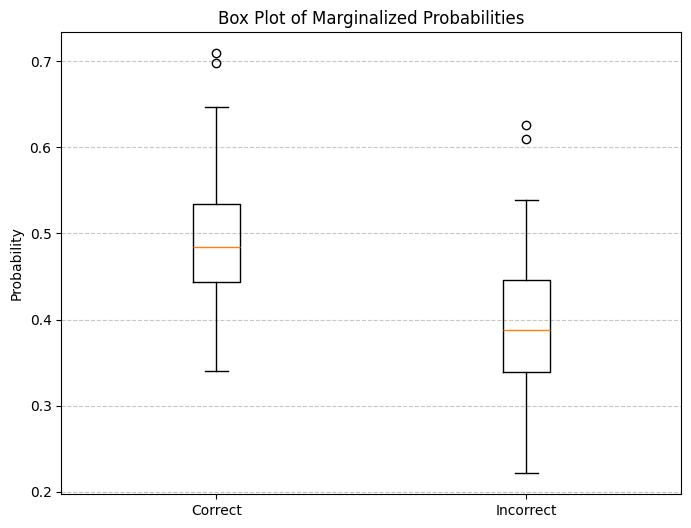

In [4]:
# Box plot for marginalized probabilities
plt.figure(figsize=(8, 6))
plt.boxplot([correct_marginalized_prob, incorrect_marginallized_prob], labels=['Correct', 'Incorrect'])

plt.title('Box Plot of Marginalized Probabilities')
plt.ylabel('Probability')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

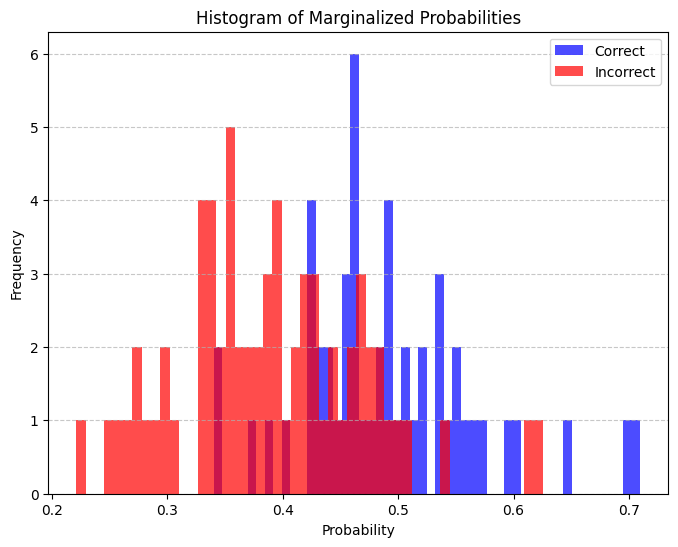

In [5]:
# Histogram for marginalized probabilities
plt.figure(figsize=(8, 6))

# Plot histograms for correct and incorrect marginalized probabilities
plt.hist(correct_marginalized_prob, bins=50, alpha=0.7, color='blue', label='Correct')
plt.hist(incorrect_marginallized_prob, bins=50, alpha=0.7, color='red', label='Incorrect')

plt.title('Histogram of Marginalized Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

118 118
AUC: 0.8276
Optimal Threshold: 0.4224


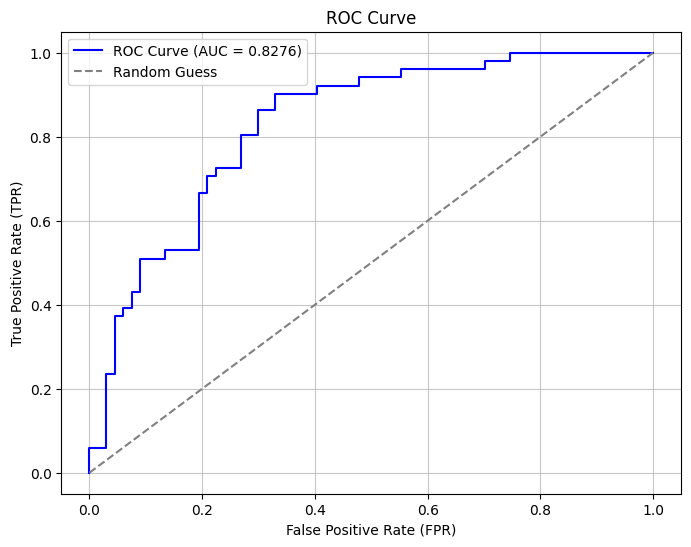

In [6]:
### AUC, AUC-ROC curve
# Combine probabilities and labels
all_probs = correct_marginalized_prob + incorrect_marginallized_prob
all_labels = [1] * len(correct_marginalized_prob) + [0] * len(incorrect_marginallized_prob)

print(len(all_probs), len(all_labels))

# Calculate AUC
auc = roc_auc_score(all_labels, all_probs)

print(f"AUC: {auc:.4f}")

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

# Youden index J = TPR + TNR - 1 = TPR - FPR
# TPR: Sensitivity / Recall / True Positive Rate = TP / (TP + FN)
# TNR: Specificity / True Negative Rate = TN / (TN + FP)
# FPR: False Positive Rate = FP / (TN + FP) = 1 - TNR
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid(alpha=0.7)

plt.show()

In [8]:
### Accuarcy
optimal_threshold = optimal_threshold
# Classify probabilities using the optimal threshold
predictions = [1 if prob >= optimal_threshold else 0 for prob in all_probs]

# Calculate accuracy
accuracy = sum([1 if pred == label else 0 for pred, label in zip(predictions, all_labels)]) / len(all_labels)
print(f"Accuracy: {accuracy:.4f}")

# Confusion matrix 값 계산
TP = sum(1 for p, l in zip(predictions, all_labels) if p == 1 and l == 1)
TN = sum(1 for p, l in zip(predictions, all_labels) if p == 0 and l == 0)
FP = sum(1 for p, l in zip(predictions, all_labels) if p == 1 and l == 0)
FN = sum(1 for p, l in zip(predictions, all_labels) if p == 0 and l == 1)

# Precision, Recall, F1
precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

#print(f"Precision: {precision:.4f}")
#print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Accuracy: 0.7712
F1-score:  0.7731
